In [1]:
## Load modules

# Standard modules
import pandas as pd
import numpy as np

# Preprocessing modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,\
 OneHotEncoder, LabelEncoder, OrdinalEncoder

# Train-test split module
from sklearn.model_selection import train_test_split

# Classifier modules
from sklearn.ensemble import RandomForestClassifier

# Regression modules
from sklearn.ensemble import RandomForestRegressor

# Model selection modules
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

# Pipeline module
from sklearn.pipeline import Pipeline

# Imputation modules
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

# Performance metric modules
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

pd.options.display.max_columns = None

# Module for categorical variables
from pandas.api.types import CategoricalDtype

# Modules for building custom encoders and transformers
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
## Load ICU Data
file ='D:/2nd sem/Deep-learning/ICU_filtered.csv'
dfICU = pd.read_csv(file, sep = ',', header = 0, index_col = 0)

print('ICU dataset')
print('-----------')
print('Initial number of samples = %d'%(dfICU.shape[0]))
print('Initial number of features = %d\n'%(dfICU.shape[1]))
dfICU.head(5)

ICU dataset
-----------
Initial number of samples = 7886
Initial number of features = 35



,Length_of_stay,In-hospital_death,Age,Gender,Height,CCU,CSRU,SICU,DiasABP_first,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,BUN_first,Creatinine_first,FiO2_first,HCO3_first,HCT_first,K_first,Lactate_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,WBC_first,Weight,pH_first,MechVent,UrineOutputSum
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,NaN,0,0,1,NaN,15.0,205.0,73.0,NaN,65.0,92.33,147.0,35.1,13.0,0.8,NaN,26.0,33.7,4.4,NaN,1.5,137.0,NaN,NaN,221.0,NaN,11.2,NaN,NaN,0,NaN
132540,8,0,76,1.0,175.3,0,1,0,67.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,35.2,16.0,0.8,1.0,21.0,24.7,4.3,NaN,3.1,139.0,34.0,344.0,164.0,105.0,7.4,80.6,7.45,1,5.0
132541,19,0,44,0.0,NaN,0,0,0,81.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,37.8,8.0,0.4,1.0,24.0,28.5,3.3,1.3,1.9,137.0,37.0,65.0,72.0,148.0,4.2,56.7,7.51,1,14.0
132543,9,0,68,1.0,180.3,0,0,0,NaN,15.0,129.0,79.0,NaN,63.0,86.67,134.0,36.3,23.0,0.9,NaN,28.0,41.3,4.0,NaN,2.1,140.0,NaN,NaN,391.0,NaN,11.5,84.6,NaN,0,NaN
132545,4,0,88,0.0,NaN,0,0,0,NaN,15.0,113.0,93.0,NaN,41.0,75.33,144.0,37.8,45.0,1.0,NaN,18.0,22.6,6.0,NaN,1.5,140.0,NaN,NaN,109.0,NaN,3.8,NaN,NaN,0,NaN


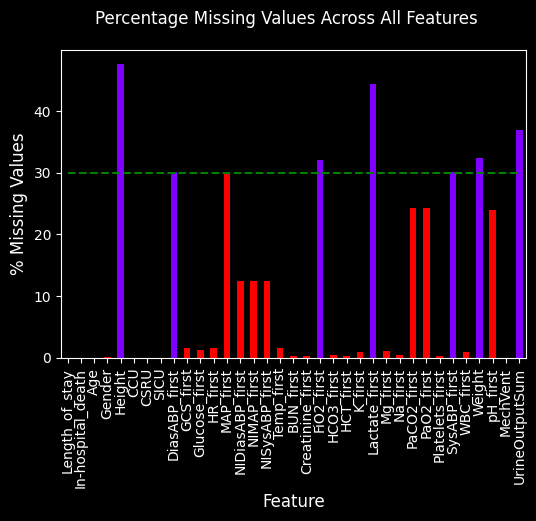

In [3]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30 # we will remove features missing in more than 20% of the samples
fig = plt.figure(figsize=(6, 4))
percent_missing = (dfICU.isna().sum() / dfICU.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(dfICU.shape[1]), np.repeat(cutoff, dfICU.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)
plt.ylabel('% Missing Values', fontsize = 12);

In [4]:
## Wrangle the dataframe
# Retain features with <= cutoff percentage missing values
dfICU = dfICU.loc[:, dfICU.columns[percent_missing <= cutoff]]

# Collate different one-hot-encoded ICU-type columns into a single column called ICU
dfICU.loc[dfICU['CCU'] == 1, 'ICU'] = 1
dfICU.loc[dfICU['CSRU'] == 1, 'ICU'] = 2
dfICU.loc[dfICU['SICU'] == 1, 'ICU'] = 3
dfICU.loc[(dfICU['CCU'] == 0 ) & (dfICU['CSRU'] == 0) & (dfICU['SICU'] == 0), 'ICU'] = 4
dfICU.drop(['CCU', 'CSRU', 'SICU'], axis = 1, inplace = True)

In [5]:
# Create lists of ordinal, categorical, and continuous features
ordinal_features = ['GCS_first']
categorical_features = [ 'Gender', 'ICU', 'MechVent']
continuous_features = dfICU.columns[~dfICU.columns.isin(ordinal_features + categorical_features)].to_list()
dfICU.head(5)

,Length_of_stay,In-hospital_death,Age,Gender,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,BUN_first,Creatinine_first,HCO3_first,HCT_first,K_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,pH_first,MechVent,ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,5,0,54,0.0,15.0,205.0,73.0,NaN,65.0,92.33,147.0,35.1,13.0,0.8,26.0,33.7,4.4,1.5,137.0,NaN,NaN,221.0,11.2,NaN,0,3.0
132540,8,0,76,1.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,35.2,16.0,0.8,21.0,24.7,4.3,3.1,139.0,34.0,344.0,164.0,7.4,7.45,1,2.0
132541,19,0,44,0.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,37.8,8.0,0.4,24.0,28.5,3.3,1.9,137.0,37.0,65.0,72.0,4.2,7.51,1,4.0
132543,9,0,68,1.0,15.0,129.0,79.0,NaN,63.0,86.67,134.0,36.3,23.0,0.9,28.0,41.3,4.0,2.1,140.0,NaN,NaN,391.0,11.5,NaN,0,4.0
132545,4,0,88,0.0,15.0,113.0,93.0,NaN,41.0,75.33,144.0,37.8,45.0,1.0,18.0,22.6,6.0,1.5,140.0,NaN,NaN,109.0,3.8,NaN,0,4.0


In [6]:
## Custom ordinal encoder
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_cols_dict: dict):
        self.ordinal_cols_dict = ordinal_cols_dict

    def fit(self, X: pd.DataFrame, y = None):
        return self

    def transform(self, X: pd.DataFrame, y = None):
        for col, order in self.ordinal_cols_dict.items():
            cat_type = CategoricalDtype(categories = self.ordinal_cols_dict[col], ordered = True)
            X[col] = X[col].astype(cat_type).factorize(sort = True)[0]
            X[col] = X[col].astype(CategoricalDtype(ordered = True))
            X[col] = X[col].replace(-1, np.nan)
        return X

    def fit_transform(self, X: pd.DataFrame, y = None):
        self.fit(X)
        return self.transform(X)

In [7]:
## Custom categorical encoder
class CustomCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols: list):
        self.categorical_cols = categorical_cols

    def fit(self, X: pd.DataFrame, y = None):
        return self

    def transform(self, X: pd.DataFrame, y = None):
        for col in self.categorical_cols:
            cat_type = 'category'
            X[col] = X[col].astype(cat_type).factorize()[0]
            X[col] = X[col].astype('category')
            X[col] = X[col].replace(-1, np.nan)
        return X

    def fit_transform(self, X: pd.DataFrame, y = None):
        self.fit(X)
        return self.transform(X)

In [16]:
## Build preprocessing pipeline for ordinal, categorical, and continuous features
# Define preprocessing pipeline for ordinal features
# Dictionary for ordinal features
ordinal_cols_dict = {
    'GCS_first': np.arange(np.max(dfICU['GCS_first']), np.min(dfICU['GCS_first'])-1, -1)
    }
ordinal_transformer = Pipeline(steps = [('customordenc', CustomOrdinalEncoder(ordinal_cols_dict)),
    ('imputer', IterativeImputer(estimator = RandomForestClassifier(n_estimators = 3),
                                 initial_strategy = 'most_frequent',
                                 missing_values = np.nan,
                                 max_iter = 10,
                                 random_state = 0))])

# Define preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps = [('customcatenc', CustomCategoricalEncoder(categorical_features)),
    ('imputer', IterativeImputer(estimator = RandomForestClassifier(n_estimators = 3),
                                 initial_strategy = 'most_frequent',
                                 missing_values = np.nan,
                                 max_iter = 10,
                                 random_state = 0))])

# Define preprocessing pipeline for continuous features
numeric_transformer = Pipeline(steps = [('imputer', IterativeImputer(estimator = RandomForestRegressor(n_estimators = 3),
                                                                     initial_strategy = 'median',
                                                                     missing_values = np.nan,
                                                                     max_iter = 10,
                                                                     random_state = 0)),
                                        ('scaler', RobustScaler())])

# Create preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('ord', ordinal_transformer, ordinal_features),
                                                 ('cat', categorical_transformer, categorical_features),
                                                 ('num', numeric_transformer, continuous_features)
                                                 ])

# Fit and transform using the preprocessor
dfICU = pd.DataFrame(preprocessor.fit_transform(dfICU))

KeyError: 'GCS_first'

In [11]:
dfICU

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,-0.454545,0.0,-0.52,1.237288,-0.576923,0.268551,0.35,0.722658,0.878788,-1.153846,-0.352941,-0.166667,0.6,0.240741,0.375,-0.666667,-0.4,0.166667,0.802682,0.193548,-0.041667,0.233333
1,12.0,1.0,1.0,1.0,-0.181818,0.0,0.36,-0.457627,0.000000,-0.169611,-1.00,-1.261652,-1.393939,-1.076923,-0.176471,-0.166667,-0.4,-0.870370,0.250,2.000000,0.0,-0.600000,0.977011,-0.266129,-0.569444,0.666667
2,8.0,0.0,2.0,1.0,0.818182,0.0,-0.92,0.152542,0.461538,1.017668,1.30,1.090448,0.454545,0.923077,-0.647059,-0.833333,0.2,-0.401235,-1.000,0.000000,-0.4,-0.300000,-0.626437,-1.008065,-1.013889,1.266667
3,0.0,1.0,2.0,0.0,-0.090909,0.0,0.04,-0.050847,-0.346154,0.664311,0.25,0.461467,0.484848,-0.230769,0.235294,0.000000,1.0,1.179012,-0.125,0.333333,0.2,0.166667,0.304598,1.564516,0.000000,0.633333
4,0.0,0.0,2.0,0.0,-0.545455,0.0,0.84,-0.322034,0.192308,0.480565,-0.85,-0.061837,0.787879,0.923077,1.529412,0.166667,-1.0,-1.129630,2.375,-0.666667,0.2,-0.533333,-0.197318,-0.709677,-1.069444,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7881,12.0,1.0,1.0,1.0,-0.363636,0.0,0.44,-0.372881,0.846154,-0.254417,-0.35,0.122750,0.545455,0.153846,0.352941,0.000000,0.0,0.154321,1.375,1.666667,-0.6,-0.500000,1.149425,-0.758065,1.180556,0.466667
7882,2.0,1.0,2.0,1.0,0.000000,0.0,0.92,-0.203390,0.346154,-0.466431,-1.30,-1.215505,-0.939394,0.461538,1.764706,2.333333,-2.4,0.302469,-1.375,-0.833333,0.4,-0.900000,-0.603448,1.088710,2.208333,-2.533333
7883,1.0,0.0,1.0,0.0,0.818182,0.0,0.12,-0.491525,-0.884615,0.127208,0.50,0.830641,0.909091,0.538462,0.529412,1.000000,-1.8,0.043210,0.125,0.000000,0.4,-1.000000,-0.379310,0.241935,0.458333,-0.333333
7884,0.0,0.0,2.0,0.0,0.181818,0.0,-0.72,-0.050847,1.038462,0.593640,1.40,1.108906,0.363636,-0.384615,-0.176471,-0.500000,0.2,-0.141975,-0.500,-0.500000,-1.6,0.800000,0.086207,0.056452,0.291667,-0.433333


In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load the dataset
# dfICU = pd.read_csv('ICU_data.csv')

# Assume that dfICU is already loaded and preprocessed

# Split the data into features and targets
X = dfICU.drop(['In_hospital_death', 'Length_of_stay'], axis=1)
y = dfICU[['In_hospital_death', 'Length_of_stay']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the model architecture
inputs = Input(shape=(X_train_preprocessed.shape[1],))
x = Dense(32, activation='relu')(inputs)
x = Dense(16, activation='relu')(x)
out1 = Dense(1, activation='sigmoid', name='survival_output')(x)  # Survival output
out2 = Dense(1, name='los_output')(x)  # Length of stay output
model = Model(inputs=inputs, outputs=[out1, out2])

# Compile the model
model.compile(optimizer='adam', loss={'survival_output': 'binary_crossentropy', 'los_output': 'mse'}, metrics=['accuracy'])

# Fit the model to the data
model.fit(X_train_preprocessed, [y_train['In_hospital_death'], y_train['Length_of_stay']], epochs=100, batch_size=10)

KeyError: "['In_hospital_death', 'Length_of_stay'] not found in axis"